In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import seaborn as sns

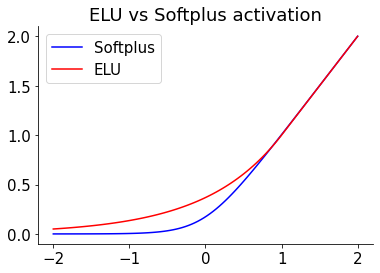

zero input: tensor(0.1733)


In [2]:
a = torch.linspace(-2,2,100)
plt.plot(a,F.softplus(a,beta=4),color='blue',label='Softplus')
plt.plot(a,F.elu(a-1)+1,color='red',label='ELU')
plt.title('ELU vs Softplus activation')
plt.legend()
sns.despine()
plt.show()

print("zero input:",F.softplus(torch.tensor(0.),beta=4))

In [3]:
def n_choose_k(n,k):
    num_permutations = np.math.factorial(n) / (np.math.factorial(k)*np.math.factorial(n-k))
    return int(num_permutations)

def n_hot_patterns(n,length):
    all_permutations = torch.tensor(list(itertools.product([0., 1.], repeat=length)))
    pattern_hotness = torch.sum(all_permutations,axis=1)
    idx = torch.where(pattern_hotness == n)[0]
    n_hot_patterns = all_permutations[idx]
    return n_hot_patterns

print(n_choose_k(7,2))
n_hot_patterns(n=2,length=4)

21


tensor([[0., 0., 1., 1.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.]])

In [4]:
class FBI_RNN(nn.Module):
    def __init__(self, input_size, Eh_size, Eo_size, Ih_size, Io_size, tau=3):
        super().__init__()
        self.in_size = input_size
        self.Eh_size = Eh_size 
        self.Ih_size = Ih_size       
        self.Eo_size = Eo_size 
        self.Io_size = Io_size 
        self.tau = tau
        
        # Hidden weights
        self.in2Eh = nn.Linear(self.in_size, self.Eh_size, bias=False)
        self.Eh2Ih = nn.Linear(self.Eh_size, self.Ih_size, bias=False)
        self.Ih2Eh = nn.Linear(self.Ih_size, self.Eh_size, bias=False)
        
        self.in2Eh.weight.data.uniform_(0, 1)
        self.Ih2Eh.weight.data.uniform_(-0.1, 0)
        self.Eh2Ih.weight.data.uniform_(0, 1)

        # Output weights
        self.Eh2Eo = nn.Linear(self.Eh_size, self.Eo_size, bias=False)
        self.Eo2Io = nn.Linear(self.Eo_size, self.Io_size, bias=False)
        self.Io2Eo = nn.Linear(self.Io_size, self.Eo_size, bias=False)     
        
        self.Eh2Eo.weight.data.uniform_(0, 1)
        self.Io2Eo.weight.data.uniform_(-0.1,0)
        self.Eo2Io.weight.data.uniform_(0, 1)
    
    
    def forward(self, input_pattern, Eh0, Ih0, Eh_preact, Ih_preact, Eo0, Io0, Eo_preact, Io_preact, act_sharpness=50):
        
        Eh_preact = Eh_preact + (-Eh_preact + self.in2Eh(input_pattern) + self.Ih2Eh(Ih0)) / self.tau
        Eh = F.softplus(Eh_preact, beta=act_sharpness)
        Eh = F.relu(Eh_preact)
        Ih_preact = Ih_preact + (-Ih_preact + self.Eh2Ih(Eh)) / self.tau
        Ih = F.softplus(Ih_preact, beta=act_sharpness)        
        Ih = F.relu(Ih_preact)        

        Eo_preact = Eo_preact + (-Eo_preact + self.Eh2Eo(Eh) + self.Io2Eo(Io0)) / self.tau
        Eo = F.softplus(Eo_preact, beta=act_sharpness)
        Eo = F.relu(Eo_preact)
        Io_preact = Io_preact + (-Io_preact + self.Eo2Io(Eo)) / self.tau
        Io = F.softplus(Io_preact, beta=act_sharpness)
        Io = F.relu(Io_preact)

        return Eh, Eh_preact, Ih, Ih_preact, Eo, Eo_preact, Io, Io_preact
    
        
    def train(self, num_epochs, num_timesteps, eval_step, num_BPTT_steps, all_patterns, learning_rate):
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        num_patterns = all_patterns.shape[0]
        
        hidden_history = torch.zeros(self.Eh_size, num_timesteps, num_patterns, num_epochs)
        hidden_inh_history = torch.zeros(self.Ih_size, num_timesteps, num_patterns, num_epochs)
        output_history = torch.zeros(self.Eo_size, num_timesteps, num_patterns, num_epochs)
        fbi_history = torch.zeros(self.Io_size, num_timesteps, num_patterns, num_epochs)
        loss_history = []
        accuracy_history = []
        
        for epoch in tqdm(range(num_epochs)):
            epoch_loss=0
            for pattern_idx in torch.randperm(num_patterns):
                
                input_pattern = all_patterns[pattern_idx]
                target  = torch.eye(self.Eo_size)[pattern_idx]
                
                # Initialize hidden layer
                Eh = torch.zeros(self.Eh_size)
                Ih = torch.zeros(self.Ih_size)
                Eh_preact = torch.zeros(self.Eh_size)
                Ih_preact = torch.zeros(self.Ih_size)
                
                # Initialize output layer
                Eo = torch.zeros(self.Eo_size)
                Io = torch.zeros(self.Io_size)
                Eo_preact = torch.zeros(self.Eo_size)
                Io_preact = torch.zeros(self.Io_size)
                
                for t in range(num_timesteps): #iterate through all timepoints of the RNN                    
                    if t >= (eval_step - num_BPTT_steps) and t <= eval_step: #truncate BPTT to only evaluate n steps from the end
                        track_grad = True
                    else:
                        track_grad = False
                        
                    with torch.set_grad_enabled(track_grad):
                        Eh, Eh_preact, Ih, Ih_preact, Eo, Eo_preact, Io, Io_preact = self.forward(input_pattern, Eh, Ih, Eh_preact, Ih_preact, Eo, Io, Eo_preact, Io_preact)

                    hidden_history[:,t,pattern_idx,epoch] = Eh.detach()
                    hidden_inh_history[:,t,pattern_idx,epoch] = Ih.detach()
                    output_history[:,t,pattern_idx,epoch] = Eo.detach()
                    fbi_history[:,t,pattern_idx,epoch] = Io.detach()

                    if t == eval_step:
                        loss = criterion(Eo, target) 
                        epoch_loss += loss.detach()
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                        self.in2Eh.weight.data = self.in2Eh.weight.data.clamp(0,100)
                        self.Ih2Eh.weight.data = self.Ih2Eh.weight.data.clamp(-100,0)
                        self.Eh2Ih.weight.data = self.Eh2Ih.weight.data.clamp(0,100)

                        self.Eh2Eo.weight.data = self.Eh2Eo.weight.data.clamp(0,100)
                        self.Io2Eo.weight.data = self.Io2Eo.weight.data.clamp(-100,0)
                        self.Eo2Io.weight.data = self.Eo2Io.weight.data.clamp(0,100)    

            # Compute final loss and accuracy at the end of this epoch
            with torch.no_grad():
                epoch_loss = 0
                accuracy = 0
                for i, pattern in enumerate(all_patterns):
                    # Initialize hidden layer
                    Eh = torch.zeros(self.Eh_size)
                    Ih = torch.zeros(self.Ih_size)
                    Eh_preact = torch.zeros(self.Eh_size)
                    Ih_preact = torch.zeros(self.Ih_size)

                    # Initialize output layer
                    Eo = torch.zeros(self.Eo_size)
                    Io = torch.zeros(self.Io_size)
                    Eo_preact = torch.zeros(self.Eo_size)
                    Io_preact = torch.zeros(self.Io_size)

                    for t in range(eval_step+1):
                        Eh, Eh_preact, Ih, Ih_preact, Eo, Eo_preact, Io, Io_preact = self.forward(pattern, Eh, Ih, Eh_preact, Ih_preact, Eo, Io, Eo_preact, Io_preact)
                    
                    target = torch.eye(self.Eo_size)[i]
                    epoch_loss += criterion(Eo, target)
                    accuracy += (torch.argmax(Eo)==i).float()*100

            loss_history.append(epoch_loss/num_patterns) 
            accuracy_history.append(accuracy/num_patterns)
                     
#             loss_history.append(epoch_loss/num_patterns)
#             output_argmax = torch.argmax(output_history[:,eval_step,:,epoch], dim=1)
#             target_argmax = torch.argmax(torch.eye(self.Eo_size), dim=1)
#             accuracy = torch.mean((output_argmax == target_argmax).float()) * 100
#             accuracy_history.append(accuracy)
       
        return output_history, fbi_history, hidden_history, hidden_inh_history, torch.tensor(loss_history), torch.tensor(accuracy_history)
    

In [5]:
seed = 123
torch.manual_seed(seed)

# Initialize RNN
input_size = 21
hidden_size = 7
hidden_inh_size = 7
output_size = 21
output_inh_size = 7

model = FBI_RNN(input_size, hidden_size, output_size, hidden_inh_size, output_inh_size)

# Train network
num_epochs = 400
num_timesteps = 13
eval_step = 12
num_BPTT_steps = 1 #how many steps in the past to backpropagate the error
# lr = 0.007
lr = 0.01

# all_patterns = n_hot_patterns(n=1,length=input_size)
all_patterns = torch.eye(21)
output_history, fbi_history, hidden_history, hidden_inh_history, loss_history, accuracy_history = model.train(num_epochs, num_timesteps, eval_step, num_BPTT_steps, all_patterns, lr)

100%|██████████| 400/400 [00:36<00:00, 10.82it/s]


Epochs to 57.0% accuracy: 254
stable accuracy + 50 epochs = 449


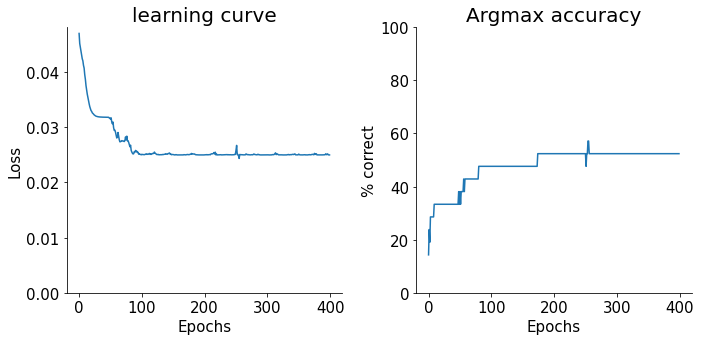

In [6]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(loss_history)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(bottom=0)
ax[0].set_title('learning curve',fontsize=20)

ax[1].plot(accuracy_history)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('% correct')
ax[1].set_ylim([0,100])

ax[1].set_title('Argmax accuracy',fontsize=20)

m = torch.max(accuracy_history)
print(f"Epochs to {torch.round(m)}% accuracy: {torch.where(accuracy_history>=m)[0][0]}")

print(f"stable accuracy + 50 epochs = {torch.where(accuracy_history<100)[0][-1]+50}")
for i in range(num_epochs):
    if torch.all(accuracy_history[i:i+50] == 100):
        print('Stable epoch:',i+50)
        epoch = i+50
        break
    else:
        epoch = -1

fig.tight_layout()
sns.despine()
plt.show()

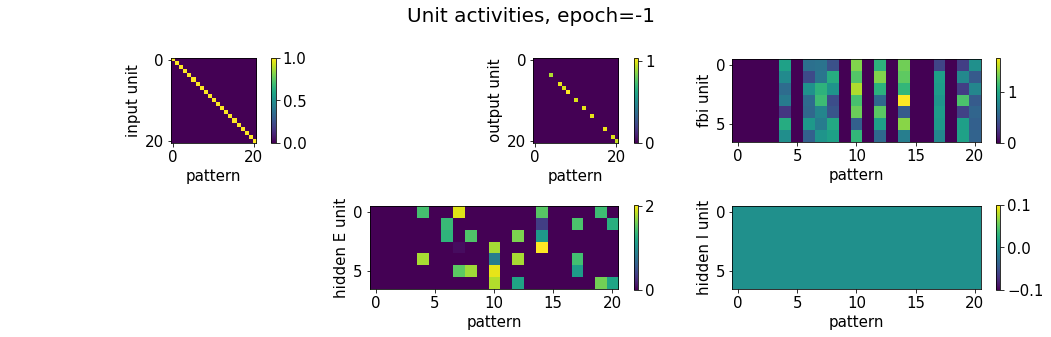

mean population sparsity (hidden) = nan


In [7]:
time = eval_step

fig, ax = plt.subplots(2,3,figsize=(15,4.5))
axis = 0,0
im = ax[axis].imshow(all_patterns.T,aspect='equal')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('input unit')

axis = 0,1
im = ax[axis].imshow(output_history[:,time,:,epoch],aspect='equal')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('output unit')

axis = 0,2
im = ax[axis].imshow(fbi_history[:,time,:,epoch],aspect='equal')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('fbi unit')

ax[1,0].axis('off')

axis = 1,1
im = ax[axis].imshow(hidden_history[:,time,:,epoch],aspect='equal')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('hidden E unit')

axis = 1,2
im = ax[axis].imshow(hidden_inh_history[:,time,:,epoch],aspect='equal')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('hidden I unit')

plt.suptitle(f"Unit activities, epoch={epoch}",fontsize=20)
plt.tight_layout()
plt.show()

# Sparsity metric from (Vinje & Gallant 2000): https://www.science.org/doi/10.1126/science.287.5456.1273
sparsity = torch.empty(input_size)
for i,pop_activity in enumerate(hidden_history[:,time,:,epoch].T):
    n = pop_activity.shape[0]
    activity_fraction = (torch.sum(pop_activity)/n)**2 / torch.sum(pop_activity**2/n)
    sparsity[i] = (1 - activity_fraction)/(1 - 1/n)   
print(f"mean population sparsity (hidden) = {torch.mean(sparsity)}")

In [8]:
import ipywidgets as widgets

def plot_activity(time):
    epoch = -1

    fig, ax = plt.subplots(2,3,figsize=(15,4.5))
    axis = 0,0
    im = ax[axis].imshow(all_patterns.T,aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('input unit')

    axis = 0,1
    im = ax[axis].imshow(output_history[:,time,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('output unit')

    axis = 0,2
    im = ax[axis].imshow(fbi_history[:,time,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('fbi unit')

    ax[1,0].axis('off')

    axis = 1,1
    im = ax[axis].imshow(hidden_history[:,time,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('hidden E unit')

    axis = 1,2
    im = ax[axis].imshow(hidden_inh_history[:,time,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('hidden I unit')

    plt.suptitle(f"Unit activities, epoch = {epoch}",fontsize=20)
    plt.tight_layout()
    plt.show()

widgets.interact(plot_activity, time=(0,num_timesteps-1,1));
# widgets.interact(plot_activity, epoch=widgets.Play(min=1,max=80));

interactive(children=(IntSlider(value=6, description='time', max=12), Output()), _dom_classes=('widget-interac…

In [9]:
import ipywidgets as widgets

def plot_activity(epoch):
    epoch = epoch*10
    time = -1

    fig, ax = plt.subplots(2,3,figsize=(15,4.5))
    axis = 0,0
    im = ax[axis].imshow(all_patterns.T,aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('input unit')

    axis = 0,1
    im = ax[axis].imshow(output_history[:,time,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('output unit')

    axis = 0,2
    im = ax[axis].imshow(fbi_history[:,time,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('fbi unit')

    ax[1,0].axis('off')

    axis = 1,1
    im = ax[axis].imshow(hidden_history[:,time,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('hidden E unit')

    axis = 1,2
    im = ax[axis].imshow(hidden_inh_history[:,time,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('hidden I unit')

    plt.suptitle("Unit activities",fontsize=20)
    plt.tight_layout()
    plt.show()

widgets.interact(plot_activity, epoch=(0,int(num_epochs/10-1),1));
# widgets.interact(plot_activity, epoch=widgets.Play(min=1,max=80));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

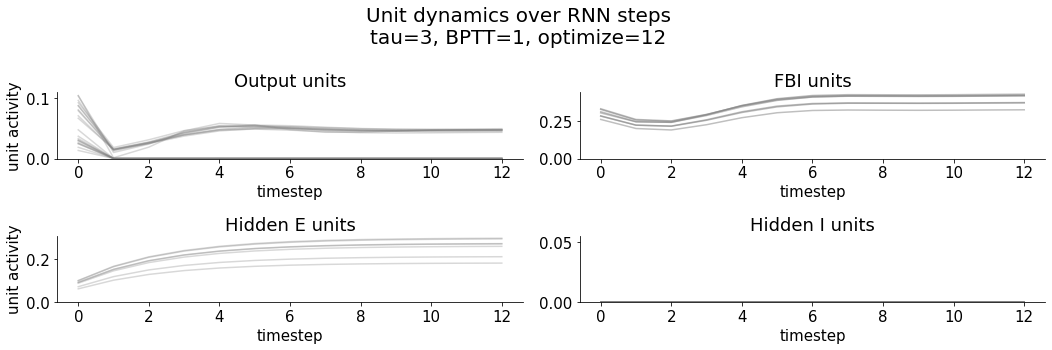

In [10]:
fig, ax = plt.subplots(2,2,figsize=(15,5))

axis = 0,0
for i in range(model.Eo_size):
    ax[axis].plot(torch.mean(output_history[i,:,:,epoch],axis=1),color='gray',alpha=0.3)
ax[axis].set_xlabel('timestep')
ax[axis].set_ylabel('unit activity')
ax[axis].set_title('Output units')
ax[axis].set_ylim(bottom=0)

axis = 0,1
for i in range(model.Io_size):
    ax[axis].plot(torch.mean(fbi_history[i,:,:,epoch],axis=1),color='gray',alpha=0.5)
ax[axis].set_xlabel('timestep')
ax[axis].set_title('FBI units')  
ax[axis].set_ylim(bottom=0)

axis = 1,0
for i in range(model.Eh_size):
    ax[axis].plot(torch.mean(hidden_history[i,:,:,epoch],axis=1),color='gray',alpha=0.3)
ax[axis].set_xlabel('timestep')
ax[axis].set_ylabel('unit activity')
ax[axis].set_title('Hidden E units')
ax[axis].set_ylim(bottom=0)

axis = 1,1
for i in range(model.Ih_size):
    ax[axis].plot(torch.mean(hidden_inh_history[i,:,:,epoch],axis=1),color='gray',alpha=0.5)
ax[axis].set_xlabel('timestep')
ax[axis].set_title('Hidden I units')  
ax[axis].set_ylim(bottom=0)
    
plt.suptitle(f"Unit dynamics over RNN steps \ntau={model.tau}, BPTT={num_BPTT_steps}, optimize={eval_step} ",fontsize=20)

sns.despine()
plt.tight_layout()
plt.show()

In [11]:
import ipywidgets as widgets

def plot_oscillation(epoch):
    
    epoch = epoch*10
    
    fig, ax = plt.subplots(2,2,figsize=(15,4.5))
    axis = 0,0
    for i in range(model.Eo_size):
        ax[axis].plot(torch.mean(output_history[i,:,:,epoch],axis=1),color='gray',alpha=0.3)
    ax[axis].set_xlabel('timestep')
    ax[axis].set_ylabel('unit activity')
    ax[axis].set_title('Output units')
    ax[axis].set_ylim(bottom=0)

    axis = 0,1
    for i in range(model.Io_size):
        ax[axis].plot(torch.mean(fbi_history[i,:,:,epoch],axis=1),color='gray',alpha=0.5)
    ax[axis].set_xlabel('timestep')
    ax[axis].set_title('FBI units')  
    ax[axis].set_ylim(bottom=0)

    axis = 1,0
    for i in range(model.Eh_size):
        ax[axis].plot(torch.mean(hidden_history[i,:,:,epoch],axis=1),color='gray',alpha=0.3)
    ax[axis].set_xlabel('timestep')
    ax[axis].set_ylabel('unit activity')
    ax[axis].set_title('Hidden E units')
    ax[axis].set_ylim(bottom=0)

    axis = 1,1
    for i in range(model.Ih_size):
        ax[axis].plot(torch.mean(hidden_inh_history[i,:,:,epoch],axis=1),color='gray',alpha=0.5)
    ax[axis].set_xlabel('timestep')
    ax[axis].set_title('Hidden I units') 
    ax[axis].set_ylim(bottom=0)

    plt.suptitle('Unit dynamics over RNN steps',fontsize=20)

    sns.despine()
    plt.tight_layout()
    plt.show()

widgets.interact(plot_oscillation, epoch=(0,int(num_epochs/10-1),1));
# widgets.interact(plot_oscillation, epoch=widgets.Play(min=1,max=50));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

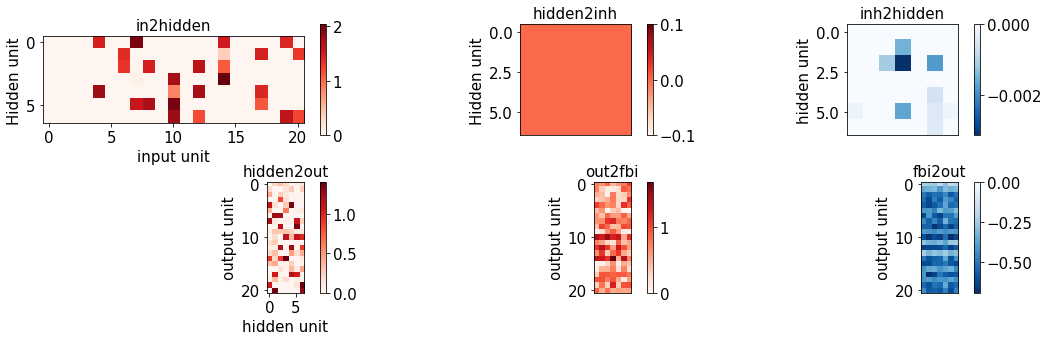

In [12]:
fig, ax = plt.subplots(2,3,figsize=(15,5))

# Hidden weights
axis = 0,0
im = ax[axis].imshow(model.in2Eh.weight.data,aspect='equal',cmap='Reds')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('input unit')
ax[axis].set_ylabel('Hidden unit')
ax[axis].set_title('in2hidden',fontsize=15)

axis = 0,1
im = ax[axis].imshow(model.Eh2Ih.weight.data.T,aspect='equal',cmap='Reds')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_ylabel('Hidden unit')
ax[axis].set_xlabel('Ih unit')
ax[axis].set_title('hidden2inh',fontsize=15)
ax[axis].get_xaxis().set_visible(False)

axis = 0,2
im = ax[axis].imshow(model.Ih2Eh.weight.data,aspect='equal',cmap='Blues_r',vmax=0)
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('Ih unit')
ax[axis].set_ylabel('hidden unit')
ax[axis].set_title('inh2hidden',fontsize=15)
ax[axis].get_xaxis().set_visible(False)


# Output weights
axis = 1,0
im = ax[axis].imshow(model.Eh2Eo.weight.data,aspect='equal',cmap='Reds')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('hidden unit')
ax[axis].set_ylabel('output unit')
ax[axis].set_title('hidden2out',fontsize=15)

axis = 1,1
im = ax[axis].imshow(model.Eo2Io.weight.data.T,aspect='equal',cmap='Reds')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_ylabel('output unit')
ax[axis].set_xlabel('Io unit')
ax[axis].set_title('out2fbi',fontsize=15)
ax[axis].get_xaxis().set_visible(False)

axis = 1,2
im = ax[axis].imshow(model.Io2Eo.weight.data, aspect='equal',cmap='Blues_r',vmax=0)
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('Io unit')
ax[axis].set_ylabel('output unit')
ax[axis].set_title('fbi2out',fontsize=15)
ax[axis].get_xaxis().set_visible(False)

plt.tight_layout()
plt.show()

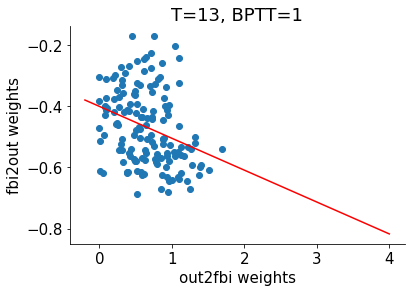

Pearson correlation: r=-0.30960393872579545, r^2=0.0958545988745261, p=0.00013568941073926035


In [13]:
from scipy import stats

x = model.Eo2Io.weight.data.T.flatten()
y = model.Io2Eo.weight.data.flatten()

plt.scatter(x,y)
plt.xlabel('out2fbi weights')
plt.ylabel('fbi2out weights')



m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(-0.2,4,2)
y_fit = m*x_fit + b
plt.plot(x_fit, y_fit, c='red')
# print('Linear regression: y = {} x + {}'.format(m,b))

plt.title(f"T={num_timesteps}, BPTT={num_BPTT_steps}")

sns.despine()
plt.show()

r_val, p_val = stats.pearsonr(x, y)
print('Pearson correlation: r={}, r^2={}, p={}'.format(r_val,r_val**2,p_val))

In [14]:
import h5py

description = "FBI_RNN_1hidden_tau_Inh7_relu"
export_file_path = "20220504_backprop_network_data.hdf5"
time = eval_step

activity_dict = {0:{'E':all_patterns.T},
                 1:{'E':hidden_history[:,time,:,epoch],'I':hidden_inh_history[:,time,:,epoch]},
                 2:{'E':output_history[:,time,:,epoch],'I':fbi_history[:,time,:,epoch]}}

weight_dict   = {0: {},
                 1: {'E_FF':model.in2Eh.weight.data, 'I_E':model.Eh2Ih.weight.data, 'E_I':model.Ih2Eh.weight.data},
                 2: {'E_FF':model.Eh2Eo.weight.data, 'I_E':model.Eo2Io.weight.data, 'E_I':model.Io2Eo.weight.data}}

metrics_dict = {'loss':loss_history,
                'accuracy':accuracy_history}


with h5py.File(export_file_path, 'a') as f:
    if description in f:
        del f[description]  
    
    model_group = f.create_group(description)    
    model_group.attrs['seed'] = seed

    activity_group = model_group.create_group('activity_dict')
    weight_group = model_group.create_group('weight_dict')
    metrics_group = model_group.create_group('metrics_dict')

    for layer in [0,1,2]:
        layer_activity = activity_group.create_group(str(layer))
        layer_weight = weight_group.create_group(str(layer))
        
        for pop in activity_dict[layer]:
            layer_activity.create_dataset(pop, data=activity_dict[layer][pop])
            
        for projection in weight_dict[layer]:
            layer_weight.create_dataset(projection, data=weight_dict[layer][projection])
            
    for metric in metrics_dict:
        metrics_group.create_dataset(metric, data=metrics_dict[metric])